## Chapter 4 Exercise Question No: 12 Solution

Training Accuracy: 0.8750
Validation Accuracy: 0.8667


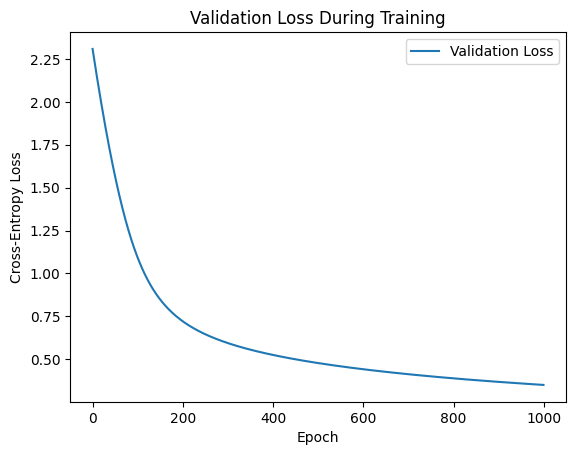

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load Iris dataset
iris = load_iris()
X = iris.data[:, [2, 3]]  # Petal length, petal width
y = iris.target

# Split and scale data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Add bias term
X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_val_b = np.c_[np.ones((X_val_scaled.shape[0], 1)), X_val_scaled]

# One-hot encode labels
def one_hot_encode(y, n_classes):
    return np.eye(n_classes)[y]

n_classes = 3
y_train_oh = one_hot_encode(y_train, n_classes)
y_val_oh = one_hot_encode(y_val, n_classes)

# Softmax function
def softmax(logits):
    exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

# Cross-entropy loss
def cross_entropy_loss(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-15), axis=1))

# Batch Gradient Descent with early stopping
def batch_gd_softmax(X_train, y_train, X_val, y_val, n_classes, eta=0.01, max_epochs=1000, patience=10):
    m, n = X_train.shape
    theta = np.random.randn(n, n_classes)  # Initialize parameters
    best_theta = None
    best_val_loss = float('inf')
    patience_counter = 0
    val_losses = []
    
    for epoch in range(max_epochs):
        # Forward pass
        logits = X_train.dot(theta)
        y_pred = softmax(logits)
        
        # Compute gradients (Equation 4-23)
        gradients = 1/m * X_train.T.dot(y_pred - y_train)
        
        # Update parameters
        theta -= eta * gradients
        
        # Validation loss
        val_logits = X_val.dot(theta)
        val_pred = softmax(val_logits)
        val_loss = cross_entropy_loss(y_val, val_pred)
        val_losses.append(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_theta = theta.copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    return best_theta, val_losses

# Train model
theta_best, val_losses = batch_gd_softmax(X_train_b, y_train_oh, X_val_b, y_val_oh, n_classes)

# Predict and evaluate
def predict(X, theta):
    logits = X.dot(theta)
    return np.argmax(softmax(logits), axis=1)

y_train_pred = predict(X_train_b, theta_best)
y_val_pred = predict(X_val_b, theta_best)
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Plot validation loss
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Validation Loss During Training')
plt.legend()
plt.savefig('softmax_val_loss.png')
plt.show()